In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from numpy.linalg import eig
import torch

In [2]:
np.random.seed(123)

In [3]:
np.set_printoptions(precision=6, suppress=True)
torch.set_printoptions(precision=6)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Times New Roman'

## Global constants (n, t0, tp, tfinal, gamma, pdi)

In [5]:
# n followers
n = 4

# time
t0 = 0.0
tp = 0.04
tf = 0.1

h = 0.0005 # time step length
num_steps = round((tf-t0)/h)
# torch.autograd.set_detect_anomaly(True)

# Caputo fractional order
q = 0.8

In [6]:
# use: pdi[pdi_key] (where pdi_key∈[1,8], => pdi[1] pdi[2] ...)
# pdi[1]=-2 => the x component of pdi between p1 and p0
# pdi[2]=2 => the y component of pdi between p1 and p0

# pdi_key = 1 # initialize the key

# counter for assigning different pdi values to different input sets
# def counter(func):
#    count = 1

#     def wrapper(*args, **kwargs):
#        nonlocal count
#         count += 1
#         if count == 9:
#            count = 1 # reaches 9 then falls back to 1, referring to the next sample leader-follower group
#         pdi_key = count
#         return func(*args, **kwargs)

#     return wrapper

In [7]:
# desired displacement between the i-th follower and the leader
# example: pdi = [[-2,2], [-2,-2], [2,-2], [2,2]]


# pdi = {1:-0.1, 2:0.1, 3:-0.1, 4:-0.1, 5:0.1, 6:-0.1, 7:0.1, 8:0.1}
# pdi = {1:-0.5, 2:0.5, 3:-0.5, 4:-0.5, 5:0.5, 6:-0.5, 7:0.5, 8:0.5}

pdi = {1:-2, 2:2, 3:-2, 4:-2, 5:2, 6:-2, 7:2, 8:2}

## More global constants (alpha, beta, c, b, kappa, k1, k2, k3)

In [9]:
# constant for virtual leader dynamics
alpha = 0.05
beta = -2.75

c = 5.75
b = 2.25
d = 1 # pinning mechananism indicator (i.e. 1: connection exists; 0: no connection between the agent and the leader)

kappa = 2

# building the matrix C, positive gains
k1 = 2.0125
k2 = 6.75
k3 = 0.005

In [10]:
# order 4 graph (according to Figure 1(b), directed blue arrows)
Vertex = {'1x', '1y', '2x', '2y', '3x', '3y', '4x', '4y'}

# adjacency matrix A_adj, 1->2, 2->3, 3->4, 4->1
A_adj = [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]]

# initialize D_dia to be a zero matrix
D_dia = [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]

# D_dia is a diagonal matrix with l_ii = ( Σ(i≠j) a_ij )
for i in range(len(A_adj)):
    D_dia[i][i] = sum(A_adj[i][j] for j in range(len(A_adj)) if i!=j)

# # D_dia is a diagonal matrix with l_ij = −a_ij, for ∀i≠j
for i in range(len(A_adj)):
    for j in range(len(A_adj)):
        if i!=j:
            D_dia[i][j] = -A_adj[i][j]

In [11]:
# Laplacian matrix of the system
L = np.array(D_dia) - np.array(A_adj)

In [12]:
# A_bar
A = [0,0,1,0,0,0,0,1,alpha,0,beta,0,0,alpha,0,beta]
A = np.array(A).reshape(4,4)

I = np.eye(4)

A_bar = np.kron(A,I).reshape(16,16)

In [13]:
ones = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
ones = np.array(ones).reshape(16,1)

# X_bar = np.kron(X, ones).reshape(16,16)
# X_bar_T = np.transpose(X_bar)

In [14]:
# PSI (C_bar)

upper_left = -(k2*c)*np.eye(8) # the upper left part of the matric C_bar
upper_right = np.zeros(64).reshape(8,8) # the lower right part of the matrix C_bar

C_upper = np.hstack((upper_left, upper_right))

lower_left = -(k2*c*d)*np.eye(8) - k1*L # the lower left part of the matric C_bar
lower_right = -(k2*c*d)*np.eye(8) - k1*L # the lower right part of the matrix C_bar

C_lower = np.hstack((lower_left, lower_right))

C_bar = np.vstack((C_upper, C_lower))
# C_bar.shape

In [15]:
# set for every PV value at different time points, for plotting and also for calculating Pc
P = {'p0x':[], 'p0y':[], 'p1x':[], 'p1y':[], 'p2x':[], 'p2y':[], 'p3x':[], 'p3y':[], 'p4x':[], 'p4y':[]}
V = {'v0x':[], 'v0y':[], 'v1x':[], 'v1y':[], 'v2x':[], 'v2y':[], 'v3x':[], 'v3y':[], 'v4x':[], 'v4y':[]}

## Initial states (pre-input datasets for calculating ξ_bar)
#### p0 v0 p1 v1 p2 v2 p3 v3 p4 v4

In [17]:
# number of followers
n = 4

# number of input points, i.e. length of p0 = 50
input_size = 1

In [18]:
# set p0 manually, create pi(p1, p2, ..., pn) randomly
def create_p(size):
    p = []
    for s in range(size):
        p_elem = np.random.uniform(0,15)
        p.append(round(p_elem,3))
    return p

p0 = np.array([[7.5], [7.5]])
pi = []

# follow the topological structure of multi-UAV systems described in figure 1??

for i in range(n):
    pi.append(np.array([create_p(input_size), create_p(input_size)]))

In [19]:
# create v0, vi(v1, v2, ..., vn)
def create_v(size): # D^gamma_t p0(t) = v0(t)? constraint?
    v = []
    for s in range(size):
        v_elem = np.random.uniform(-5,5)
        v.append(round(v_elem,3))
    return v

v0 = np.array([[2.5], [2.5]])
vi = []

for i in range(n):
    vi.append(np.array([create_v(input_size), create_v(input_size)]))

#### Pre-input dataset: input_pv

In [21]:
input_pv = []
for i in range(input_size):
    for j in range(n):
        input_elem_x = [p0[0][i], v0[0][i], pi[j][0][i], vi[j][0][i]]
        input_elem_y = [p0[1][i], v0[1][i], pi[j][1][i], vi[j][1][i]]
        input_pv.append(input_elem_x)
        input_pv.append(input_elem_y)

In [22]:
P['p0x'].append(input_pv[0][0]); V['v0x'].append(input_pv[0][1])
P['p0y'].append(input_pv[1][0]); V['v0y'].append(input_pv[1][1])
P['p1x'].append(input_pv[0][2]); V['v1x'].append(input_pv[0][3])
P['p1y'].append(input_pv[1][2]); V['v1y'].append(input_pv[1][3])
P['p2x'].append(input_pv[2][2]); V['v2x'].append(input_pv[2][3])
P['p2y'].append(input_pv[3][2]); V['v2y'].append(input_pv[3][3])
P['p3x'].append(input_pv[4][2]); V['v3x'].append(input_pv[4][3])
P['p3y'].append(input_pv[5][2]); V['v3y'].append(input_pv[5][3])
P['p4x'].append(input_pv[6][2]); V['v4x'].append(input_pv[6][3])
P['p4y'].append(input_pv[7][2]); V['v4y'].append(input_pv[7][3])

In [23]:
P

{'p0x': [7.5],
 'p0y': [7.5],
 'p1x': [10.447],
 'p1y': [4.292],
 'p2x': [3.403],
 'p2y': [8.27],
 'p3x': [10.792],
 'p3y': [6.347],
 'p4x': [14.711],
 'p4y': [10.272]}

In [24]:
V

{'v0x': [2.5],
 'v0y': [2.5],
 'v1x': [-0.191],
 'v1y': [-1.079],
 'v2x': [-1.568],
 'v2y': [2.29],
 'v3x': [-0.614],
 'v3y': [-4.403],
 'v4x': [-1.02],
 'v4y': [2.38]}

## Function 1: Numerical solver for Caputo fractional order system

In [26]:
from scipy.special import gamma
import matplotlib.pyplot as plt

In [27]:
# calculate needed params: p_hat, v_hat, p_bar for the leader_follower dynamics
def phi_calculator(k3, t0, tp, t):
    # under condition sigma(t)==1
    # ϕσ(t)(t) = e^{k3(t0+tp−t)}
    e = np.exp(1)
    if t < tp:
        return (e**(k3*(t0+tp-t)))-1
    elif t >= tp:
        return e**(-t)

def dot_phi_calculator(k3, t0, tp, t):
    e = np.exp(1)
    if t < tp:
        return (-k3)*(e**(k3*(t0+tp-t)))
    elif t >= tp:
        return (-1)*e**(-t)

def p_hat_calculator(pi, p0, pdi_val):
    return pi-p0-pdi_val

def v_hat_calculator(vi, v0):
    return vi-v0

def f(v):
    return 0.05*(v**2)

In [28]:
# virtual leader and virtual follower dynamics step by step (final choice)
# counter added for assigning the pdi_key
def f_leader_follower(X, t, pdi_val, key):
    p0, v0, pi, vi = X

    u_p = (-k2) * c * p_hat_calculator(pi, p0, pdi_val)
    u_pt1 = k3 * (dot_phi_calculator(k3, t0, tp, t) / phi_calculator(k3, t0, tp, t)) * p_hat_calculator(pi, p0, pdi_val)

    # see equation 7
    # Ni: neighbor set for every pi which has connection with others
    # follower_index: the input lines are divided into x and y components
#    follower_index = np.round(int(np.ceil(pdi_key/2)))

#    if Ni[follower_index]==[]: # if the neighbor set of the current pi is empty, Pc=0
#        Pc = 0
#    else:
#        # save the pj_hat and vj_hat into one dictionary? so that they could be retrieved (PVj[j][0]: pj_hat)
#        Pc = np.sum( p_hat_calculator(pi, p0, pdi_val) - PVj[j][0] + v_hat_calculator(vi, v0) - PVj[j][1])

    Pc = 0
    if key == 1:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v4x'][-1], V['v0x'][-1]))
        # Pl = 0
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 2:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v4y'][-1], V['v0y'][-1]))
        # Pl = 0
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 3:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v1x'][-1], V['v0x'][-1]))
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 4:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v1y'][-1], V['v0y'][-1]))
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 5:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v2x'][-1], V['v0x'][-1]))
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 6:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v2y'][-1], V['v0y'][-1]))
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 7:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v3x'][-1], V['v0x'][-1]))
        # Pl = 0
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))
    elif key == 8:
        Pc = (-b)*(v_hat_calculator(vi, v0) - v_hat_calculator(V['v3y'][-1], V['v0y'][-1]))
        # Pl = 0
        Pl = (-c) * d * (p_hat_calculator(pi, p0, pdi_val) + v_hat_calculator(vi, v0))

    u_v = alpha * pdi_val + k1*Pc + k2*Pl
    u_pt2 = k3 * (dot_phi_calculator(k3, t0, tp, t) / phi_calculator(k3, t0, tp, t)) * v_hat_calculator(vi, v0)


    # ================================================================================
    # ================================================================================

    # get the dynamics for one specific set of states [p0, v0, pi, vi]

    val = np.array([[v0,
                     alpha*p0 + beta*v0 + f(v0),
                     vi + u_p + u_pt1,
                     alpha*pi + beta*vi + f(vi) + u_v + u_pt2]])

    # =================================================================================
    # =================================================================================

    return val

In [29]:
def f_abm_solver(f_uav, initial_states, pdi, q, t0, h, num_steps, current_step, key):
    # initialize arrays to store the solution and time points
    num_equations = len(initial_states)
    solution = np.zeros((num_steps+1, num_equations))

    # set initial conditions
    solution[0] = initial_states

    # Euler's method for 2 very first solutions
    t = round(t0+h, 5)
    f = f_uav(solution[0], t, pdi, key)
    h_q = (h**q) / gamma(q+1)
    solution[1] = solution[0] + h_q*f

    # Fractional Adams-Bashforth iteration
    for j in range(0, num_steps):
        t = round(t0+j*h, 5)

        # first-order FABM
        sum_prev = 0
        for k in range(1, 0+1):
            sum_prev += (solution[j-k] - solution[j-k-1]) / (h**q)

        f = f_uav(solution[j], t, pdi, key)
        solution[j+1] = solution[j] + (h**q)/gamma(q+1) * (f+sum_prev)

    return solution[current_step] # the current step solution

## Function 2: Caputo Fractional Derivative Calculator

In [31]:
import control as ct

# need a calculator which can work with tensors
from pyfod.fod import caputo
from scipy.interpolate import CubicSpline

In [32]:
from scipy.special import gamma

In [33]:
# calculate parameter: aa
# input the subscript l and the Caputo fraction order q
def aa(l, q):
    val = ((l+1)**(1-q)) - (l**(1-q))
    return val

# calculate parameter: bb
def bb(l, q):
    val = (((l+1)**(2-q)-l**(2-q))/(2-q)) - (((l+1)**(1-q)+l**(1-q))/2)
    return val

# calculate parameter: cc
def cc(l, q):
    val = 1/6 * (((l+1)**(1-q))+2*(l**(1-q))) + (1/(2-q))*(l**(2-q)) - ((((l+1)**(3-q))-(l**(3-q)))/((2-q)*(3-q)))
    return val

# calculate parameter: dd
def dd(j, l, q):
    # j: jth time point
    # l: subscript for dd, smaller than j. (for example in the summation term l = j-k-1)
    # q: the Caputo fractional order
    val = np.zeros(j)

    if j == 1:
        val[0] = 1
    elif j == 2:
        val[0] = aa(0, q) + bb(0, q)
        val[1] = aa(1, q) - bb(0, q)
    elif j == 3:
        val[0] = aa(0, q) + bb(0, q) + cc(0, q)
        val[1] = aa(1, q) + bb(1, q) - bb(0, q) - 2*cc(0, q)
        val[2] = aa(2, q) - bb(1, q) + cc(0, q)
    elif j >= 4:
        val[0] = aa(0, q) + bb(0, q) + cc(0, q)
        val[1] = aa(1, q) + bb(1, q) - bb(0, q) + cc(1, q) - 2*cc(0, q)
        # l = [2, j-3]
        for i in range(2, j-2):
            val[i] = aa(i, q) + bb(i, q) - bb(i-1, q) + cc(i, q) - 2*cc(i-1, q) + cc(i-2, q)
        val[j-2] = aa(j-2, q) + bb(j-2, q) - bb(j-3, q) - 2*cc(j-3, q) + cc(j-4, q)
        val[j-1] = aa(j-1, q) - bb(j-2, q) + cc(j-3, q)

    return val[l]

In [34]:
def Caputo_frac_derivative_calculator(t, t0, h, H_val, q):
    # t: the current time t, used in all same-time calculations (H(t), R(t), phi(t)...) at that time point
    # h: time step h = (tp-t0)/num_steps
    # V_val: length = j, until the jth time point t
    # q: the Caputo fractional order, pre-defined

    # output a single value dH, Caputo fractional order derivative of H(t)
    # jth time point t stating from t0
    j = round((t-(t0))/h)

    summation = 0
    if j == 1:
        # summation term doesn't exist, k cannot go from 1 to 0
        summation = 0
    else:
        # calculate the summation term
        # summation index from 1 to j-1
        for k in range(1,j):
            dd_jk = dd(j, j-k, q) # param dd inside the summation with subscript j-k
            dd_jk1 = dd(j, j-k-1, q) # param dd inside the summation with subscript j-k-1
            summation = summation + ((dd_jk1-dd_jk)*H_val[k])

    dd_0 = dd(j, 0, q)
    dd_j1 = dd(j, j-1, q)

    dV = ((h**(-q))/gamma(2-q)) * (dd_0*H_val[-1] - summation - dd_j1*H_val[0])

    return dV # return just the single dh at that time point

## Function 3: Fractional Integral Calculator

In [36]:
# computes the fractional integral of f(t) from t_a to t_a+(Delta_t*num_steps) of order q
def frac_integral(f_list, t_a, t_b, q, Delta_t):
    # f(t): function to integrate
    # t_a: lower limit of integration

    # initialize fractional integral
    If_val = 0.0

    # number of steps
    integ_steps = round((t_b-t_a)/Delta_t)

    # time steps
    t_values = np.linspace(t_a, t_b, integ_steps+1)

    # numerical integration using trapezoidal rule
    for i in range(1, integ_steps+1):  # include t_b boundary
        tau = t_values[i-1]
        tau_next_step = t_values[i]

        # avoid dividing by 0 at tau = t_b
        if i == integ_steps:
            If_val = If_val + ((t_b-tau)**(q-1)*(f_list[i-1])) * Delta_t / 2

        else:
            # trapezoidal rule: average of two consecutive points; integrand: (-f_list(tau)) / (t_b-tau)^(alpha)
            If_val = If_val + ((t_b-tau)**(q-1)*(f_list[i-1]) + (t_b-tau_next_step)**(q-1)*(f_list[i])) * Delta_t / 2

    If_val = If_val / gamma(1+q)

    return If_val

## PTs_NN for learning suitable set of matrix elements (to make (15) valid)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [39]:
# using the previously-calculated results (change the directories if you want to use)
'''
n_features = 16
learning_rate = 0.005

M1_mat = np.loadtxt('/Users/ekeulseuji-/Downloads/M1_mat.txt')
M2_mat = np.loadtxt('/Users/ekeulseuji-/Downloads/M2_mat.txt')

# upper triangular mat
M1_upper_tri = []
M2_upper_tri = []

for i in range(n_features):
    for j in range(i,n_features):
        M1_upper_tri.append(M1_mat[i,j])
        M2_upper_tri.append(M2_mat[i,j])
'''
# uncomment to use

n_features = 16
learning_rate = 0.005

In [40]:
class PTs_Net(nn.Module):
    
    ''' # if you want to use the existing weight matrices then uncomment this + comment the __init__() func behind
    
    def __init__(self, M1_w, M2_w):
        super(PTs_Net, self).__init__()
        
        self.weight = nn.Parameter(torch.tensor(M1_w, dtype=torch.float), requires_grad=True)
        self.weight2 = nn.Parameter(torch.tensor(M2_w, dtype=torch.float), requires_grad=True)
    '''
    
    
    def __init__(self, n_features):
        super(PTs_Net, self).__init__()
        
        # (16*16)/2+(16/2)
        # of elements in the upper triangular
        param = [np.random.randint(1,3) for _ in range(136)] 
        param2 = [np.random.randint(1,3) for _ in range(136)]
        
        # multiply diagonal elements by 2 for better initialization (P condition will be satisfied faster)
        
        diagonal_index = []
        i_sum = 1
        for i in range(16,0,-1):
            diagonal_index.append(i_sum)
            i_sum = i_sum + i
            
        for index in diagonal_index:
            param[index-1] = param[index-1]*2
            param2[index-1] = param2[index-1]*2
        
        self.weight = nn.Parameter(torch.tensor(param, dtype=torch.float), requires_grad=True)
        self.weight2 = nn.Parameter(torch.tensor(param2, dtype=torch.float), requires_grad=True)
    

    def forward(self, in_X):
        # in_X shape(1,n_features), X_bar_T
        weight_no_grad = self.weight.clone().detach().numpy()
        weight2_no_grad = self.weight2.clone().detach().numpy()

        M1 = np.zeros((n_features,n_features))
        M2 = np.zeros((n_features,n_features))

        n = 0
        for i in range(n_features):
            for j in range(i,n_features):
                M1[i,j] = weight_no_grad[n]
                M2[i,j] = weight2_no_grad[n]
                n = n + 1

        M1 = torch.tensor(np.transpose(M1), dtype=torch.float)
        M2 = torch.tensor(np.transpose(M2), dtype=torch.float)
        # making the mat a complete symmetric matrix

        m = 0
        for i in range(n_features):
            for j in range(i,n_features):
                M1[i,j] = self.weight[m] # keep the lower-triangular elements update-able
                M2[i,j] = self.weight2[m]
                m = m + 1

        # H(t) = X^T M1 X
        H = torch.matmul(torch.matmul(torch.tensor(in_X, dtype=torch.float), M1),
                         torch.tensor(np.transpose(in_X).reshape(-1,1), dtype=torch.float))

        # W(t) = X^T M2 X
        W = torch.matmul(torch.matmul(torch.tensor(in_X, dtype=torch.float), M2),
                         torch.tensor(np.transpose(in_X).reshape(-1,1), dtype=torch.float))
        

        return H, M1, W, M2

In [41]:
# define the NN model and the weight optimizer

# if you want to use the existing weight matrices then uncomment this + comment the PTs_Net(n_features) behind
'''
PTs_model = PTs_Net(M1_upper_tri, M2_upper_tri)
'''

PTs_model = PTs_Net(n_features)


optimizer = optim.Adam(PTs_model.parameters(), lr=learning_rate) # gradient ascent? + lr
# optimizer = optim.RMSprop(PTs_model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.8)
# optimizer = optim.SGD(PTs_model.parameters(), lr=learning_rate, momentum=0.75)

## Main

#### For every input set (one sample leader-follower group), calculate $\bar{X}$, the Pts_NN input

At 25 th learning epoch,
Model Loss = 257.8739
Min eigenvalue of M1: -1.2472
Min eigenvalue of M2: -1.33154
H(t0+tp): 0.00032
loss1 (varphi>0): 0.0
loss2 (-cDU<I(-W)): 0.0


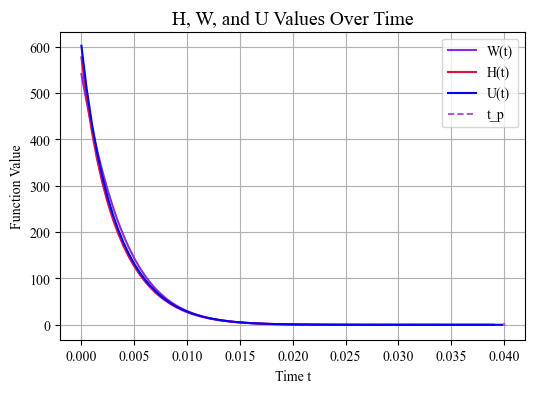



At 50 th learning epoch,
Model Loss = 135.00876
Min eigenvalue of M1: -0.72893
Min eigenvalue of M2: -0.62115
H(t0+tp): 0.00038
loss1 (varphi>0): 0.0
loss2 (-cDU<I(-W)): 0.0


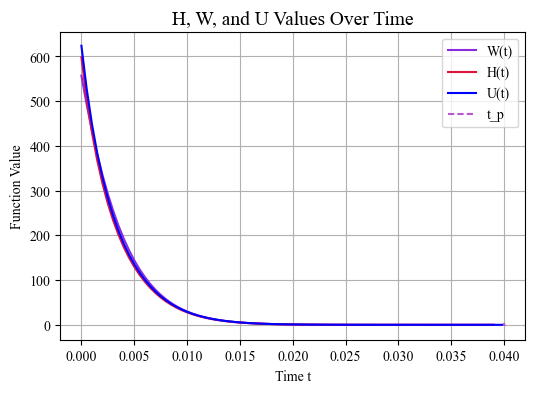



At 75 th learning epoch,
Model Loss = 34.84536
Min eigenvalue of M1: -0.27711
Min eigenvalue of M2: -0.07134
H(t0+tp): 0.00043
loss1 (varphi>0): 0.0
loss2 (-cDU<I(-W)): 0.0


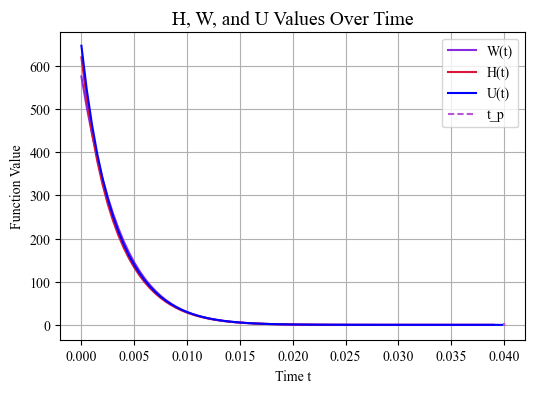



============================== SIMULATION DONE ==============================
At Iteration 92
min_eig_M1 =  tensor(0.002570, grad_fn=<MinBackward1>)
min_eig_M2 =  tensor(0.053323, grad_fn=<MinBackward1>)




In [44]:
# num_steps = round((tp-t0)/h)
# torch.autograd.set_detect_anomaly(True)
losses = []

model_loss = 1000
n_iter = 0 # number of learning iterations
max_iter = 300

zero_tensor = torch.tensor(0, dtype=torch.float)

while model_loss > 0 and n_iter <= max_iter: 
    H_list = []; U_list = []; W_list = []; X_norm_list = [] # ||x(t)||
    t_list = []; varphiH_list = []; cD_pH_minus_InegW_list = []
    
    # loss will not be calculated for t0 (the 0th time point)
    running_loss = zero_tensor
    
    loss1_sum = zero_tensor; loss2_sum = zero_tensor; loss3_sum = zero_tensor
    
    for t in np.arange(t0, tf+h, h):
        t_list.append(t)
        pdi_key = 1
    
        # p_bar = [p1_hat^T, p2_hat^T, p3_hat^T, P4_hat^T]^T
        # p_bar = [p1_hat_x, p1_hat_y, p2_hat_x, p2_hat_y, p3_hat_x, p3_hat_y, p4_hat_x, p4_hat_y]^T
        p_bar = []; v_bar = []
    
        for pv_line in input_pv:
            pdi_value = pdi[pdi_key]
    
            pv_sol = f_abm_solver(f_leader_follower, np.array(pv_line), pdi_value, q, t0, h, num_steps, round((t-t0)/h), pdi_key)
            
            if pdi_key == 1:
                csi_hat_norm = 0
                if n_iter == 0:
                    P['p0x'].append(pv_sol[0]); V['v0x'].append(pv_sol[1]); P['p1x'].append(pv_sol[2]); V['v1x'].append(pv_sol[3])
                p1_hat_x = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[1]); v1_hat_x = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p1_hat_x**2 + v1_hat_x**2

            elif pdi_key == 2:
                if n_iter == 0:
                    P['p0y'].append(pv_sol[0]); V['v0y'].append(pv_sol[1]); P['p1y'].append(pv_sol[2]); V['v1y'].append(pv_sol[3])
                p1_hat_y = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[2]); v1_hat_y = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p1_hat_y**2 + v1_hat_y**2

            elif pdi_key == 3:
                if n_iter == 0:
                    P['p2x'].append(pv_sol[2]); V['v2x'].append(pv_sol[3])
                p2_hat_x = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[3]); v2_hat_x = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p2_hat_x**2 + v2_hat_x**2

            elif pdi_key == 4:
                if n_iter == 0:
                    P['p2y'].append(pv_sol[2]); V['v2y'].append(pv_sol[3])
                p2_hat_y = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[4]); v2_hat_y = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p2_hat_y**2 + v2_hat_y**2

            elif pdi_key == 5:
                if n_iter == 0:
                    P['p3x'].append(pv_sol[2]); V['v3x'].append(pv_sol[3])
                p3_hat_x = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[5]); v3_hat_x = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p3_hat_x**2 + v3_hat_x**2

            elif pdi_key == 6:
                if n_iter == 0:
                    P['p3y'].append(pv_sol[2]); V['v3y'].append(pv_sol[3])
                p3_hat_y = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[6]); v3_hat_y = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p3_hat_y**2 + v3_hat_y**2

            elif pdi_key == 7:
                if n_iter == 0:
                    P['p4x'].append(pv_sol[2]); V['v4x'].append(pv_sol[3])
                p4_hat_x = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[7]); v4_hat_x = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p4_hat_x**2 + v4_hat_x**2

            elif pdi_key == 8:
                if n_iter == 0:
                    P['p4y'].append(pv_sol[2]); V['v4y'].append(pv_sol[3])
                p4_hat_y = p_hat_calculator(pv_sol[2], pv_sol[0], pdi[8]); v4_hat_y = v_hat_calculator(pv_sol[3], pv_sol[1])
                csi_hat_norm = csi_hat_norm + p4_hat_y**2 + v4_hat_y**2

            pdi_key = pdi_key + 1
    
        # should go to zero as time processes,
        # meaning that the leader-follower system will maintain their pre-specified realtive positions and velocities
        X_norm_list.append(np.sqrt(csi_hat_norm))
        
        p_bar = [p1_hat_x, p1_hat_y, p2_hat_x, p2_hat_y, p3_hat_x, p3_hat_y, p4_hat_x, p4_hat_y] # .T
        v_bar = [v1_hat_x, v1_hat_y, v2_hat_x, v2_hat_y, v3_hat_x, v3_hat_y, v4_hat_x, v4_hat_y] # .T
    
        # [p_bar^T, v_bar^T]^T
        X_bar = np.transpose(np.hstack((np.array(p_bar), np.array(v_bar)))).reshape(16,1)   # shape = (16,1)
        X_bar_T = np.transpose(X_bar).reshape(1,16)   # shape = (1,16)
    
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Neural
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Network
        
        H_t, M1_t, W_t, M2_t = PTs_model(X_bar_T)
        H_list.append(H_t) # ------------------------------------------- H(~all t)
        W_list.append(W_t) # ------------------------------------------- W(~all t)

        phi_val = phi_calculator(k3, t0, tp, t)
        
        if round(t,5)<=round(t0+tp,5):
            U_t = (phi_val**(-k3))*H_t  
            U_list.append(U_t) # ------------------- U(~tp)
            

        # running loss2 3 is not calculated until the lists contain 3 or more elements
        if round(t,5)>=round(t0+h,5):
            # t_interval = np.linspace(t0, tf-h, num_steps)
            # t_subinterval = t_interval[:round(t/h)]
            # V_func = CubicSpline(t_subinterval, V_list, bc_type='natural')
            # cD_V = CaputoDict_V['fd']

            # varphi positive definite (for all t) ============================================================
            Bar_A = torch.tensor(A_bar, dtype=torch.float)
            Psi = torch.tensor(C_bar, dtype=torch.float)
            Bar_A_T = torch.tensor(np.transpose(A_bar), dtype=torch.float)
            Psi_T = torch.tensor(np.transpose(C_bar), dtype=torch.float)
            
            M1APsi = torch.matmul(M1_t, (Bar_A+Psi)) + torch.matmul((Bar_A_T+Psi_T), M1_t) + 2*kappa*M1_t
            maxeigM1 = torch.max(torch.linalg.eigvals(torch.linalg.inv(M1_t)).real)

            varphi = (-1)*(M1APsi*maxeigM1) 
            # min_eig_varphi = torch.min(torch.linalg.eigvals(varphi).real)
            # PHI = k3*(dot_phi/phi) * np.eye(16)
            # PHI = torch.tensor(PHI, dtype=torch.float)
            
            # loss1 = torch.max(torch.tensor(0, dtype=torch.float), (-min_eig_varphi)) # varphi positive 
            # loss1_sum = loss1_sum + loss1
            
            # neg_varphi_H = (-1)*varphi
            # the kron step acts the same as np.tile
            X_bar_kron = np.kron(X_bar, ones).reshape(16,16)
            X_bar_kron_T = np.transpose(X_bar_kron)

            X_bar_kron = torch.tensor(X_bar_kron, dtype=torch.float)
            X_bar_kron_T = torch.tensor(X_bar_kron_T, dtype=torch.float)

            varphi_H_mat = torch.matmul(torch.matmul(torch.matmul(varphi, X_bar_kron_T), M1_t), X_bar_kron)
            varphi_H = torch.diag(varphi_H_mat)[0]
            varphiH_list.append(varphi_H)
            
            loss1 = torch.max(zero_tensor, 0.0-varphi_H) # varphi H positive -> varphi positive
            loss1_sum = loss1_sum + loss1

            # -cD_U < I(-W) ============= (for t from t0 to t0+tp) ========================================
            # until U_list = [U(t0), U(t0+h), U(t0+2h)]
            if round(t,5)>=round(t0+h,5) and round(t,5)<=round(t0+tp-h,5):
                # cD_U = Caputo_frac_derivative_calculator(t, h, U_list, q)
                # phi_X_bar_kron_T = torch.tensor((phi_val**(-k3)), dtype=torch.float)*X_bar_kron_T
                # varphi_phiH = torch.matmul(torch.matmul(torch.matmul(varphi,phi_X_bar_kron_T),M1_t),X_bar_kron)
                # neg_varphi_U = (-1)*cD_t*(torch.diag(varphi_phiH)[0])  # - varphi cD_t phi^(-k3) H
                # nvU_HphidcDt = neg_varphi_U + H_t*(phi_val**(-k3))*d_cD_t
            
                cD_U = Caputo_frac_derivative_calculator(t, t0, h, U_list, q)
                
                neg_W_list = [-elem for elem in W_list]
                I_neg_W = frac_integral(neg_W_list, t0, t, 1-q, h)  # I(-W) 
                
                cD_pH_minus_InegW_list.append(I_neg_W-cD_U) # should be >= 0
    
                loss2 = torch.max(zero_tensor, (cD_U-I_neg_W)) # cD_U < I(-W) 
                
            else:
                loss2 = torch.tensor(0, dtype=torch.float)
                
            loss2_sum = loss2_sum + loss2
            
            running_loss = running_loss + loss1 + loss2
        
    # all eigenvalues should be greater than 0 (for positive definite square matrix)
    min_eig_M1 = torch.min(torch.linalg.eigvals(M1_t).real)
    min_eig_M2 = torch.min(torch.linalg.eigvals(M2_t).real)

    model_loss = 100*torch.max(zero_tensor,-min_eig_M2) + 100*torch.max(zero_tensor,-min_eig_M1) + running_loss/200

    if model_loss.item()<=0.00001:
        print('============================== SIMULATION DONE ==============================')
        np.savetxt('/Users/ekeulseuji/Downloads/M1_mat.txt', M1_t.detach().numpy(), fmt='%.4f', delimiter=' ')
        np.savetxt('/Users/ekeulseuji/Downloads/M2_mat.txt', M2_t.detach().numpy(), fmt='%.4f', delimiter=' ')
        print('At Iteration', n_iter)
        print('min_eig_M1 = ', min_eig_M1)
        print('min_eig_M2 = ', min_eig_M2)
        print('\n')
        break;

    elif model_loss.item()>0.00001:
        optimizer.zero_grad()
        # backward propagation
        model_loss.backward()
    
        optimizer.step()
    
        # check: M1 M2 are positive definite or not for t∈[t0,tf)
    
        # save and print the loss
        losses.append(model_loss.item())
    
    n_iter = n_iter + 1

    if n_iter%25==0:
        print('At', n_iter, 'th learning epoch,')
        print('Model Loss =', round(model_loss.item(),5))
        print('Min eigenvalue of M1:', round(min_eig_M1.item(),5))
        print('Min eigenvalue of M2:', round(min_eig_M2.item(),5))
        
        print('H(t0+tp):', round(H_list[int(round(tp-t0,5)/h)].item(),5))
        # print('Caputo fractional dreivative of H:', round(cD_H.item(),4))

        print('loss1 (varphi>0):', round(loss1_sum.item(),4))
        print('loss2 (-cDU<I(-W)):', round(loss2_sum.item(),4))
        
        plt.figure(figsize=(6,4))

        W_nlist = [w_val.item() for w_val in W_list]
        H_nlist = [h_val.item() for h_val in H_list]

        plt.plot(t_list[:int((tp-t0)/h)-1], W_nlist[:int((tp-t0)/h)-1], label='W(t)', color='blueviolet')
        plt.plot(t_list[:int((tp-t0)/h)-1], H_nlist[:int((tp-t0)/h)-1], label='H(t)', color='crimson')
        # plt.plot(t_list[1:int(tp/h)-1], R_nlist[:-1], label='R(t)', color='darkcyan')
    
        U_nlist = [U_val.item() for U_val in U_list]
        plt.plot(t_list[:int(len(U_list))], U_nlist, label='U(t)', color='blue')

        tp_y = [i for i in np.arange(-2, 5, 0.5)]
        tp_x = [tp]*len(tp_y)
        plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

        plt.title('H, W, and U Values Over Time', fontname='Times New Roman', fontsize=14)
        plt.xlabel('Time t')
        plt.ylabel('Function Value')

        plt.grid()
        plt.legend()
        plt.show()

        print('\n')

In [45]:
H_list[0]

tensor([[634.801392]], grad_fn=<MmBackward0>)

In [46]:
model_loss

tensor([[0.]], grad_fn=<AddBackward0>)

In [47]:
running_loss

tensor([[0.]], grad_fn=<AddBackward0>)

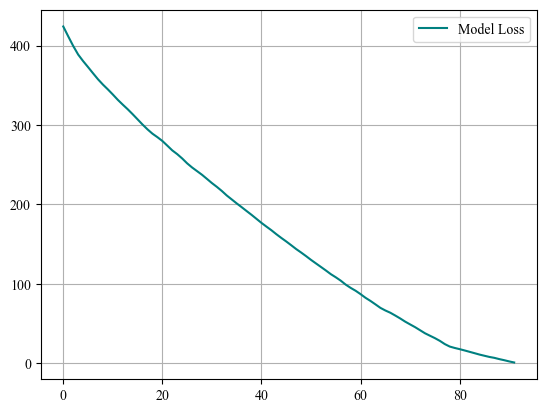

In [48]:
indices = [i for i in range(len(losses))]
plt.plot(indices, losses, label='Model Loss', color='teal')
plt.grid()
plt.legend()

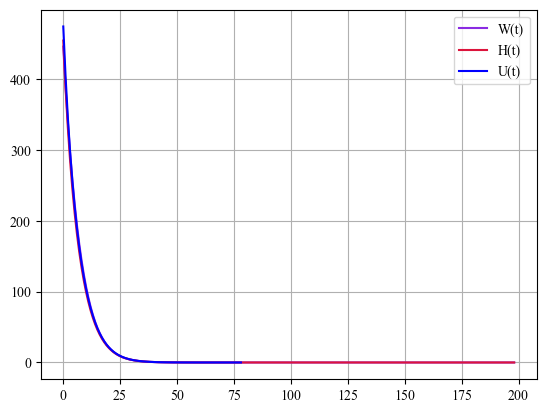

In [49]:
W_indices = [i for i in range(len(W_list[2:]))]
W_nlist = [w_val.item() for w_val in W_list[2:]]

H_indices = [i for i in range(len(H_list[2:]))]
H_nlist = [h_val.item() for h_val in H_list[2:]]

# R_indices = [i for i in range(len(R_list))]
# R_nlist = [r_val.item() for r_val in R_list]

plt.plot(W_indices, W_nlist, label='W(t)', color='blueviolet')
plt.plot(H_indices, H_nlist, label='H(t)', color='crimson')
# plt.plot(R_indices, R_nlist, label='R(t)', color='dodgerblue')
# plt.plot(indices, losses, label='Model Loss', color='teal')

U_indices = [i for i in range(len(U_list[2:]))]
U_nlist = [U_val.item() for U_val in U_list[2:]]

plt.plot(U_indices, U_nlist, label='U(t)', color='blue')

plt.grid()
plt.legend()

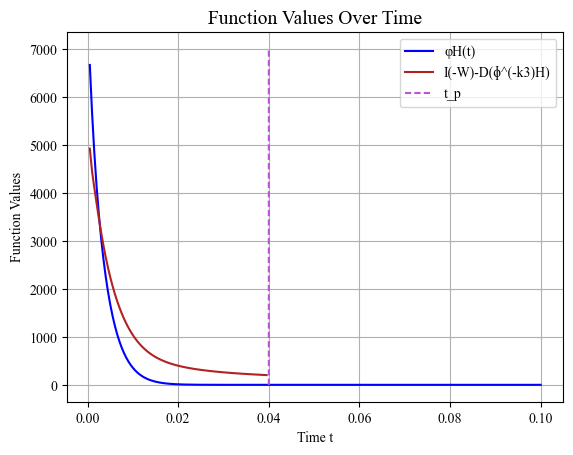

In [186]:
all_t_list = t_list[1:]
tp_list = [i for i in np.arange(t0+h, tp, h)]
vH_nlist = [(1/100000)*vh_val.item() for vh_val in varphiH_list]
WH_nlist = [(1/10)*wh_val.item() for wh_val in cD_pH_minus_InegW_list]

plt.plot(all_t_list, vH_nlist, label='φH(t)', color='blue')
plt.plot(tp_list, WH_nlist, label='I(-W)-D(ɸ^(-k3)H)', color='firebrick')

tp_y = [i for i in np.arange(-2, 7000, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.title('Function Values Over Time', fontname='Times New Roman', fontsize=14)
plt.xlabel('Time t')
plt.ylabel('Function Values', fontname='Times New Roman')

plt.legend()
plt.grid()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_hw.pdf')
plt.show()

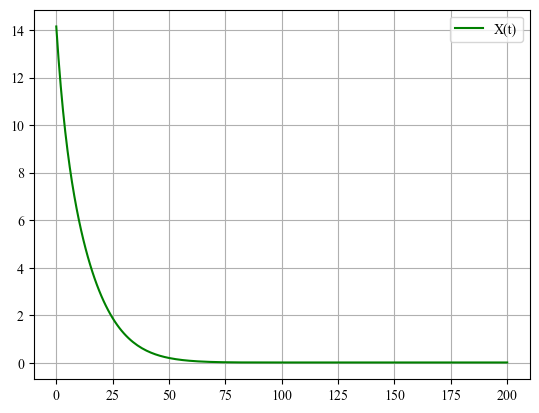

In [51]:
X_indices = [i for i in range(len(X_norm_list))]
X_nlist = [x_val.item() for x_val in X_norm_list]
plt.plot(X_indices, X_nlist, label='X(t)', color='green')
plt.legend()
plt.grid()

In [52]:
M1_t

tensor([[4.298469, 1.958019, 1.295460, 1.105404, 1.818630, 0.820961, 1.270326,
         1.916381, 0.856036, 1.920281, 1.006482, 1.710813, 1.806056, 1.752412,
         1.292557, 1.154583],
        [1.958019, 2.377902, 1.039981, 1.650041, 1.765860, 1.131757, 1.229945,
         1.713706, 1.083675, 1.664242, 1.184649, 1.056519, 1.652351, 1.329456,
         1.999736, 0.976484],
        [1.295460, 1.039981, 4.299566, 0.994686, 0.777649, 0.879530, 1.301514,
         1.837087, 0.810978, 0.941094, 1.953146, 1.717015, 1.777862, 1.770664,
         1.302676, 1.087641],
        [1.105404, 1.650041, 0.994686, 2.368645, 1.253950, 1.724003, 1.735955,
         1.306391, 1.111755, 1.172669, 1.067287, 1.865255, 1.273081, 1.676806,
         1.891702, 1.262486],
        [1.818630, 1.765860, 0.777649, 1.253950, 4.242767, 1.874785, 1.712807,
         1.247803, 2.154307, 2.096097, 2.085861, 1.150568, 1.239874, 0.942685,
         1.752014, 1.121594],
        [0.820961, 1.131757, 0.879530, 1.724003, 1.874785, 2

In [53]:
H_nlist[-1]

0.00022538799385074526

In [54]:
I_neg_W

tensor([[-31.957817]], grad_fn=<DivBackward0>)

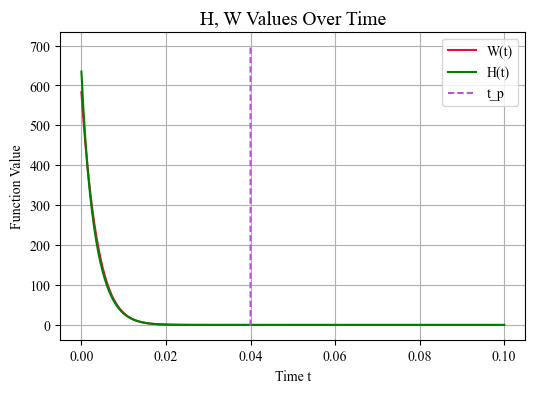

In [55]:
plt.figure(figsize=(6,4))

W_nlist = [w_val.item() for w_val in W_list]
H_nlist = [h_val.item() for h_val in H_list]

plt.plot(t_list, W_nlist, label='W(t)', color='crimson')
plt.plot(t_list, H_nlist, label='H(t)', color='green')
# plt.plot(t_list[1:int(tp/h)-1], R_nlist[:-1], label='R(t)', color='darkcyan')

tp_y = [i for i in np.arange(-2, 700, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.title('H, W Values Over Time', fontname='Times New Roman', fontsize=14)
plt.xlabel('Time t')
plt.ylabel('Function Value', fontname='Times New Roman')

plt.grid()
plt.legend()
plt.show()

In [56]:
W_nlist[-1]

0.0002676511649042368

In [57]:
min_eig_M1

tensor(0.002570, grad_fn=<MinBackward1>)

In [58]:
min_eig_M2

tensor(0.053323, grad_fn=<MinBackward1>)

# 3D plot?

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [61]:
plot_n = round((t-t0)/h)
t_plot = t_list

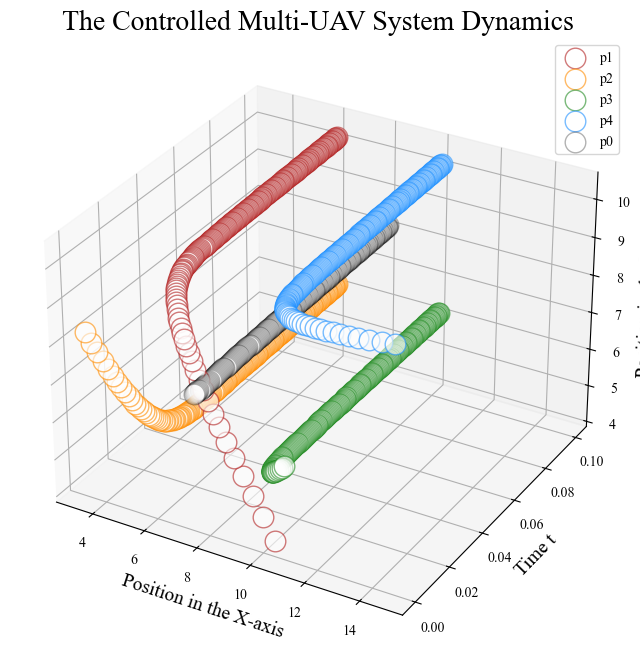

In [172]:
p0_plot = []
p1_plot = []
p2_plot = []
p3_plot = []
p4_plot = []

plt.rcParams['font.family'] = 'Times New Roman'

# plot the starting n points?
for i in range(plot_n):
    p0_plot.append([t_plot[i], P['p0x'][1:][i], P['p0y'][1:][i]])
    p1_plot.append([t_plot[i], P['p1x'][1:][i], P['p1y'][1:][i]])
    p2_plot.append([t_plot[i], P['p2x'][1:][i], P['p2y'][1:][i]])
    p3_plot.append([t_plot[i], P['p3x'][1:][i], P['p3y'][1:][i]])
    p4_plot.append([t_plot[i], P['p4x'][1:][i], P['p4y'][1:][i]])

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111, projection='3d')

for elem in p0_plot:
    ax.scatter(elem[1], elem[0], elem[2], s=220, c=elem[1], cmap='Greys', edgecolor='black', linewidths=1, alpha=0.3)

for elem in p1_plot:
    ax.scatter(elem[1], elem[0], elem[2], s=220, c=elem[1], cmap='Greys', edgecolor='firebrick', linewidths=1, alpha=0.6)

for elem in p2_plot:
    ax.scatter(elem[1], elem[0], elem[2], s=220, c=elem[1], cmap='Greys', edgecolor='darkorange', linewidths=1, alpha=0.6)

for elem in p3_plot:
    ax.scatter(elem[1], elem[0], elem[2], s=220, c=elem[1], cmap='Greys', edgecolor='forestgreen', linewidths=1, alpha=0.6)

for elem in p4_plot:
    ax.scatter(elem[1], elem[0], elem[2], s=220, c=elem[1], cmap='Greys', edgecolor='dodgerblue', linewidths=1, alpha=0.6)


ax.scatter(P['p1x'][-1], t_plot[-1], P['p1y'][-1], s=220, c=P['p1x'][-1], cmap='Greys', edgecolor='firebrick', linewidths=1, label='p1', alpha=0.6)
# ax.annotate('p1', (P['p1x'][plot_n], P['p1y'][plot_n]))  

ax.scatter(P['p2x'][-1], t_plot[-1], P['p2y'][-1], s=220, c=P['p2x'][-1], cmap='Greys', edgecolor='darkorange', linewidths=1, label='p2', alpha=0.6)
# ax.annotate('p2', (P['p2x'][0], P['p2y'][0]))  

ax.scatter(P['p3x'][-1], t_plot[-1], P['p3y'][-1], s=220, c=P['p3x'][-1], cmap='Greys', edgecolor='forestgreen', linewidths=1, label='p3', alpha=0.6)
# ax.annotate('p3', (P['p3x'][0], P['p3y'][0]))  

ax.scatter(P['p4x'][-1], t_plot[-1], P['p4y'][-1], s=220, c=P['p4x'][-1], cmap='Greys', edgecolor='dodgerblue', linewidths=1, label='p4', alpha=0.6)
# ax.annotate('p4', (P['p4x'][0], P['p4y'][0]))  

ax.scatter(P['p0x'][-1], t_plot[-1], P['p0y'][-1], s=220, c=P['p0x'][-1], cmap='Greys', edgecolor='black', linewidths=1, label='p0', alpha=0.3)
# ax.annotate('p0', (P['p0x'][plot_n], P['p0y'][plot_n]))  

'''
x_axis = np.linspace(0,15,20)
z_axis = np.linspace(0,15,20)
xa, za = np.meshgrid(x_axis, z_axis)
y_axis = tp + 0*xa + 0*za

ax.plot_surface(xa, y_axis, za, color='m', alpha=0.15)
'''

ax.set_xlabel('Position in the X-axis', fontname='Times New Roman', fontsize=14)
ax.set_ylabel('Time t', fontname='Times New Roman', fontsize=14)
ax.set_zlabel('Position in the Y-axis', fontname='Times New Roman', fontsize=14)

ax.set_title('The Controlled Multi-UAV System Dynamics', fontname='Times New Roman', fontsize=20)

plt.grid()
plt.legend()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_3d.pdf')
plt.show()

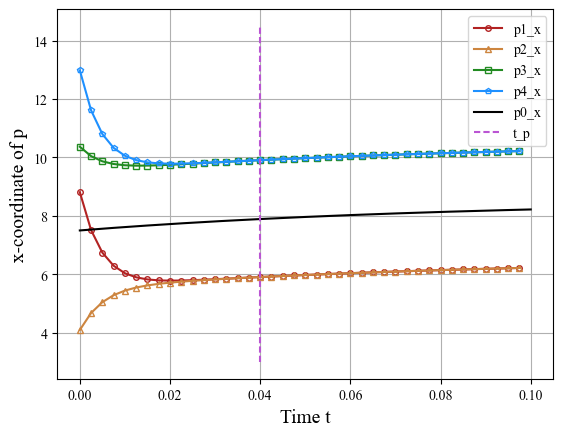

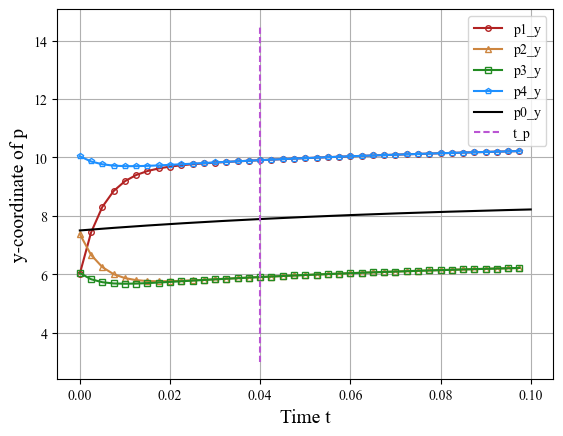

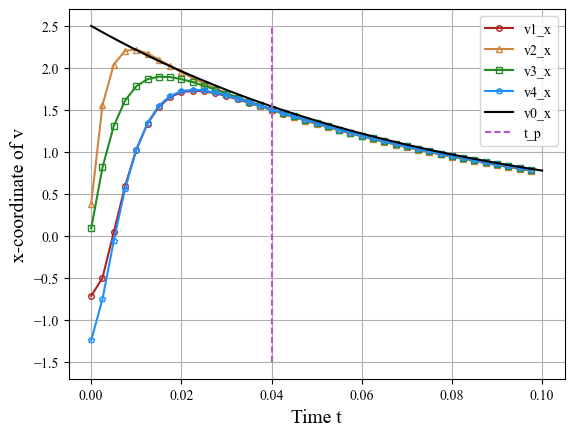

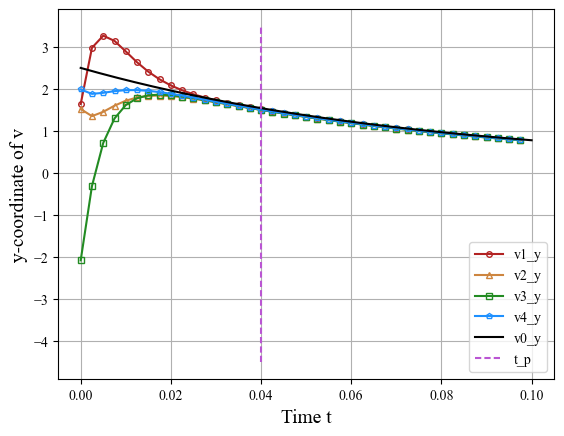

In [63]:
colors = ['firebrick', 'peru', 'forestgreen', 'dodgerblue']
markers = ['o', '^', 's', 'p']

for i, plot_list in enumerate([P['p1x'][::5], P['p2x'][::5], P['p3x'][::5], P['p4x'][::5]]):
    plt.plot(t_plot[:-1][::5], plot_list[1:], label=f'p{i+1}_x', color=colors[i], marker=markers[i], markerfacecolor='none', markersize=4)
    # plt.title('X-axis Position for the Agents from t0 to tp', fontname='Times New Roman', fontsize=16)
    plt.xlabel('Time t', fontname='Times New Roman', fontsize=14)
    plt.ylabel('x-coordinate of p', fontname='Times New Roman', fontsize=14)
    plt.legend()
    plt.grid(True)

plt.plot(t_plot, P['p0x'][1:], label='p0_x', color='black')

tp_y = [i for i in np.arange(3, 15, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.legend()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_px.pdf')
plt.show()

for i, plot_list in enumerate([P['p1y'][::5], P['p2y'][::5], P['p3y'][::5], P['p4y'][::5]]):
    plt.plot(t_plot[:-1][::5], plot_list[1:], label=f'p{i+1}_y', color=colors[i], marker=markers[i], markerfacecolor='none', markersize=4)
    # plt.title('Y-axis Position for the Agents from t0 to tp', fontname='Times New Roman', fontsize=16)
    plt.xlabel('Time t', fontname='Times New Roman', fontsize=14)
    plt.ylabel('y-coordinate of p', fontname='Times New Roman', fontsize=14)
    plt.legend()
    plt.grid(True)
    

plt.plot(t_plot, P['p0y'][1:], label='p0_y', color='black')

tp_y = [i for i in np.arange(3, 15, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.legend()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_py.pdf')
plt.show()


for i, plot_list in enumerate([V['v1x'][::5], V['v2x'][::5], V['v3x'][::5], V['v4x'][::5]]):
    plt.plot(t_plot[:-1][::5], plot_list[1:], label=f'v{i+1}_x', color=colors[i], marker=markers[i], markerfacecolor='none', markersize=4)
    plt.xlabel('Time t', fontname='Times New Roman', fontsize=14)
    plt.ylabel('x-coordinate of v', fontname='Times New Roman', fontsize=14)
    plt.legend()
    plt.grid(True)

plt.plot(t_plot, V['v0x'][1:], label='v0_x', color='black')    

tp_y = [i for i in np.arange(-1.5, 3, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.legend()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_vx.pdf')
plt.show()

for i, plot_list in enumerate([V['v1y'][::5], V['v2y'][::5], V['v3y'][::5], V['v4y'][::5]]):
    plt.plot(t_plot[:-1][::5], plot_list[1:], label=f'v{i+1}_y', color=colors[i], marker=markers[i], markerfacecolor='none', markersize=4)
    plt.xlabel('Time t', fontname='Times New Roman', fontsize=14)
    plt.ylabel('y-coordinate of v', fontname='Times New Roman', fontsize=14)
    plt.legend()
    plt.grid(True)
    
plt.plot(t_plot, V['v0y'][1:], label='v0_y', color='black')    

tp_y = [i for i in np.arange(-4.5, 4, 0.5)]
tp_x = [tp]*len(tp_y)
plt.plot(tp_x, tp_y, label='t_p', color='mediumorchid', dashes=[3,1.5])

plt.legend()
plt.savefig('/Users/ekeulseuji/Downloads/PTS_vy.pdf')
plt.show()

In [64]:
np.savetxt('/Users/ekeulseuji/Downloads/M1_mat.txt', M1_t.detach().numpy(), fmt='%.4f', delimiter=' ')

In [65]:
np.savetxt('/Users/ekeulseuji/Downloads/M2_mat.txt', M2_t.detach().numpy(), fmt='%.4f', delimiter=' ')

In [66]:
M1_t

tensor([[4.298469, 1.958019, 1.295460, 1.105404, 1.818630, 0.820961, 1.270326,
         1.916381, 0.856036, 1.920281, 1.006482, 1.710813, 1.806056, 1.752412,
         1.292557, 1.154583],
        [1.958019, 2.377902, 1.039981, 1.650041, 1.765860, 1.131757, 1.229945,
         1.713706, 1.083675, 1.664242, 1.184649, 1.056519, 1.652351, 1.329456,
         1.999736, 0.976484],
        [1.295460, 1.039981, 4.299566, 0.994686, 0.777649, 0.879530, 1.301514,
         1.837087, 0.810978, 0.941094, 1.953146, 1.717015, 1.777862, 1.770664,
         1.302676, 1.087641],
        [1.105404, 1.650041, 0.994686, 2.368645, 1.253950, 1.724003, 1.735955,
         1.306391, 1.111755, 1.172669, 1.067287, 1.865255, 1.273081, 1.676806,
         1.891702, 1.262486],
        [1.818630, 1.765860, 0.777649, 1.253950, 4.242767, 1.874785, 1.712807,
         1.247803, 2.154307, 2.096097, 2.085861, 1.150568, 1.239874, 0.942685,
         1.752014, 1.121594],
        [0.820961, 1.131757, 0.879530, 1.724003, 1.874785, 2

In [67]:
M2_t

tensor([[2.363757, 1.707031, 1.655290, 1.207654, 1.203105, 1.670235, 1.019406,
         0.869077, 1.315575, 1.799641, 1.053817, 1.707392, 2.237932, 0.704978,
         0.918117, 1.233693],
        [1.707031, 4.318574, 1.216685, 0.836531, 1.747593, 1.291252, 1.212012,
         1.837940, 0.957293, 0.900574, 1.696687, 1.214074, 0.981412, 1.296090,
         0.849614, 2.049654],
        [1.655290, 1.216685, 2.348073, 1.751352, 1.818940, 1.325196, 0.942565,
         1.202425, 1.678407, 1.194074, 1.038381, 1.304962, 1.759276, 1.250512,
         1.106451, 0.750942],
        [1.207654, 0.836531, 1.751352, 4.306874, 1.267645, 1.693678, 1.771266,
         1.985321, 2.046580, 1.225541, 2.158328, 1.709868, 2.015249, 1.811955,
         1.194078, 1.013458],
        [1.203105, 1.747593, 1.818940, 1.267645, 4.288708, 1.692156, 1.719869,
         2.153112, 1.885868, 1.292466, 1.298032, 1.744674, 1.907274, 1.756349,
         1.228842, 1.851404],
        [1.670235, 1.291252, 1.325196, 1.693678, 1.692156, 2

In [68]:
P['p0x'][int(tp/h)]

7.886396686384956

In [69]:
P['p0y'][int(tp/h)]

7.886396686384956

In [70]:
V['v0x'][int(tp/h)]

1.5513565194087773

In [71]:
V['v0y'][int(tp/h)]

1.5513565194087773

In [72]:
P['p1x'][int(tp/h)]

5.887032229498026

In [73]:
P['p1y'][int(tp/h)]

9.885553282960934

In [74]:
P['p2x'][int(tp/h)]

5.885816403997557

In [75]:
P['p2y'][int(tp/h)]

5.886766884525279

In [76]:
P['p3x'][int(tp/h)]

9.88662252418664

In [77]:
P['p3y'][int(tp/h)]

5.886232944466869

In [78]:
P['p4x'][int(tp/h)]

9.887270337650088

In [79]:
P['p4y'][int(tp/h)]

9.886611318913788

In [80]:
V['v0x'][int(tp/h)]

1.5513565194087773

In [81]:
V['v0y'][int(tp/h)]

1.5513565194087773

In [82]:
V['v1x'][int(tp/h)]

1.5420029993948472

In [83]:
V['v1y'][int(tp/h)]

1.561254208859767

In [84]:
V['v2x'][int(tp/h)]

1.5486970947833576

In [85]:
V['v2y'][int(tp/h)]

1.5452850989342617

In [86]:
V['v3x'][int(tp/h)]

1.5539383111884844

In [87]:
V['v3y'][int(tp/h)]

1.5459965312581445

In [88]:
V['v4x'][int(tp/h)]

1.5503359674699586

In [89]:
V['v4y'][int(tp/h)]

1.5541511965515633

## just to make nicer pics ☆ ☆ ☆ ☆ ☆ 